# Лабораторная работа №1. Прогнозирование рейтинга риска:
## Пользовательская линейная регрессия с инженерией признаков и ансамблевыми методами
## Суровегин Никита Сергеевич М8О-311Б-23

## 1. Инициализация и импорты

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import inspect
from datetime import datetime

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

EPS = 1e-3
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Импортированы все библиотеки")

Импортированы все библиотеки


## 2. Вспомогательные функции и метрики

In [4]:
# ============================================================================
# ============================================================================

def calc_mse(actual_vals, predicted_vals):
    """Mean Squared Error"""
    return np.mean((np.array(actual_vals) - np.array(predicted_vals)) ** 2)

def calc_mae(actual_vals, predicted_vals):
    """Mean Absolute Error"""
    return np.mean(np.abs(np.array(actual_vals) - np.array(predicted_vals)))

def calc_rmse(actual_vals, predicted_vals):
    """Root Mean Squared Error"""
    return np.sqrt(calc_mse(actual_vals, predicted_vals))

def calc_r2(actual_vals, predicted_vals):
    """R² Score (Coefficient of Determination)"""
    actual_vals, predicted_vals = np.array(actual_vals), np.array(predicted_vals)
    residuals = np.sum((actual_vals - predicted_vals) ** 2)
    total_variance = np.sum((actual_vals - np.mean(actual_vals)) ** 2)
    return 1 - (residuals / (total_variance + 1e-8))

def calc_mape(actual_vals, predicted_vals):
    """Mean Absolute Percentage Error"""
    actual_vals = np.array(actual_vals, dtype=np.float64)
    predicted_vals = np.array(predicted_vals, dtype=np.float64)
    mask = np.abs(actual_vals) > EPS
    if np.sum(mask) == 0:
        return 0
    return np.mean(np.abs((actual_vals[mask] - predicted_vals[mask]) / (np.abs(actual_vals[mask]) + EPS))) * 100

print("Метрики определены")

Метрики определены


## 3. Реализация пользовательской линейной регрессии

In [5]:
class LinearRegressionCustom:
    """
    Custom Linear Regression with three optimization methods:
    - 'analytical': Closed-form solution via normal equations
    - 'gd': Full-batch Gradient Descent
    - 'sgd': Stochastic Gradient Descent with mini-batches
    """
    
    def __init__(self, method='analytical', learning_rate=0.01, num_epochs=1000, 
                 batch_sz=32, verbose=False):
        self.method = method
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_sz = batch_sz
        self.weights = None
        self.intercept = None
        self.verbose = verbose
        self.loss_history = []

    def fit(self, features_arr, target_arr):
        """Train the model"""
        features_arr = np.array(features_arr, dtype=np.float64)
        target_arr = np.array(target_arr, dtype=np.float64)
        n_samples, n_features = features_arr.shape

        if self.method == 'analytical':
            X_with_bias = np.c_[np.ones((n_samples, 1)), features_arr]
            try:
                theta = np.linalg.pinv(X_with_bias.T.dot(X_with_bias)).dot(X_with_bias.T).dot(target_arr)
            except:
                theta = np.linalg.lstsq(X_with_bias, target_arr, rcond=None)[0]
            self.intercept = theta[0]
            self.weights = theta[1:]

        elif self.method == 'gd':
            self.weights = np.zeros(n_features)
            self.intercept = 0
            for epoch in range(self.num_epochs):
                predictions = np.dot(features_arr, self.weights) + self.intercept
                errors = predictions - target_arr
                dw = (2 / n_samples) * np.dot(features_arr.T, errors)
                db = (2 / n_samples) * np.sum(errors)
                self.weights -= self.learning_rate * dw
                self.intercept -= self.learning_rate * db
                loss = np.mean(errors ** 2)
                self.loss_history.append(loss)

        elif self.method == 'sgd':
            self.weights = np.zeros(n_features)
            self.intercept = 0
            for epoch in range(self.num_epochs):
                permutation = np.random.permutation(n_samples)
                features_shuffled = features_arr[permutation]
                target_shuffled = target_arr[permutation]
                for batch_start in range(0, n_samples, self.batch_sz):
                    batch_end = min(batch_start + self.batch_sz, n_samples)
                    X_batch = features_shuffled[batch_start:batch_end]
                    y_batch = target_shuffled[batch_start:batch_end]
                    predictions = np.dot(X_batch, self.weights) + self.intercept
                    errors = predictions - y_batch
                    dw = (2 / len(X_batch)) * np.dot(X_batch.T, errors)
                    db = (2 / len(X_batch)) * np.sum(errors)
                    self.weights -= self.learning_rate * dw
                    self.intercept -= self.learning_rate * db
                predictions_full = np.dot(features_arr, self.weights) + self.intercept
                loss = np.mean((predictions_full - target_arr) ** 2)
                self.loss_history.append(loss)

    def predict(self, features_arr):
        """Make predictions"""
        features_arr = np.array(features_arr, dtype=np.float64)
        return np.dot(features_arr, self.weights) + self.intercept

print("Линейная Регрессия определена")

Линейная Регрессия определена


## 4. Функции обработки данных

In [7]:
def signed_logarithm(data_arr):
    """Apply log transformation while preserving sign"""
    return np.sign(data_arr) * np.log1p(np.abs(data_arr))

def extract_temporal_features(dataframe, date_column):
    """Extract temporal features from date column"""
    if date_column not in dataframe.columns:
        return
    parsed_dates = pd.to_datetime(dataframe[date_column], errors="coerce")
    dataframe[f"{date_column}_Year"] = parsed_dates.dt.year
    dataframe[f"{date_column}_Month"] = parsed_dates.dt.month
    dataframe[f"{date_column}_DayOfWeek"] = parsed_dates.dt.dayofweek
    dataframe[f"{date_column}_Quarter"] = parsed_dates.dt.quarter
    dataframe.drop(columns=[date_column], inplace=True)

def create_binned_feature(dataframe, column_name, boundaries, fmt="num"):
    """Create binned categorical features"""
    if column_name not in dataframe.columns:
        return
    bin_labels = []
    for i in range(len(boundaries) - 1):
        lower, upper = boundaries[i], boundaries[i + 1]
        if np.isinf(upper):
            bin_labels.append(f"{lower}{'+' if fmt == 'num' else ''}")
        else:
            bin_labels.append(f"{lower}-{upper}")
    dataframe[f"{column_name}Band"] = (pd.cut(dataframe[column_name], bins=boundaries, 
                                               labels=bin_labels, include_lowest=True).astype(str))

def engineer_features(dataframe):
    """Create advanced features for better model performance"""
    # ===== FINANCIAL RATIOS =====
    dataframe["InterestMargin"] = dataframe["InterestRate"] - dataframe["BaseInterestRate"]
    dataframe["LoanToIncomeRatio"] = dataframe["LoanAmount"] / (dataframe["AnnualIncome"] + EPS)
    total_monthly_debt = dataframe["MonthlyLoanPayment"] + dataframe["MonthlyDebtPayments"]
    dataframe["DebtServiceCoverage"] = total_monthly_debt / (dataframe["MonthlyIncome"] + EPS)
    dataframe["AvailableIncome"] = dataframe["MonthlyIncome"] - total_monthly_debt
    dataframe["AssetLiquidityRatio"] = dataframe["TotalAssets"] / (dataframe["TotalLiabilities"] + EPS)
    dataframe["LiabilityDelta"] = dataframe["TotalLiabilities"] - dataframe["TotalAssets"]
    dataframe["LogLiabilityDelta"] = signed_logarithm(dataframe["LiabilityDelta"])
    dataframe.drop(columns=["LiabilityDelta"], inplace=True)
    
    # ===== NET WORTH METRICS =====
    dataframe["NetWorthLeverageRatio"] = dataframe["NetWorth"] / (dataframe["TotalLiabilities"] + EPS)
    dataframe["WealthToEarnings"] = dataframe["NetWorth"] / (dataframe["AnnualIncome"] + EPS)
    
    # ===== CREDIT METRICS =====
    dataframe["UtilizationPerAvailableLine"] = dataframe["CreditCardUtilizationRate"] / (dataframe["NumberOfOpenCreditLines"] + 1)
    dataframe["InquiryDensity"] = dataframe["NumberOfCreditInquiries"] / (dataframe["NumberOfOpenCreditLines"] + 1)
    
    # ===== DEMOGRAPHICS =====
    dataframe["DependentAdjustedIncome"] = dataframe["AnnualIncome"] / (dataframe["NumberOfDependents"] + 1)
    dataframe["ExperienceIndexToAge"] = dataframe["Experience"] / (dataframe["Age"] + EPS)
    dataframe["LoanTermYears"] = dataframe["LoanDuration"] / 12.0
    dataframe["CreditHistoryRatio"] = dataframe["LengthOfCreditHistory"] / (dataframe["Age"] + EPS)
    dataframe["IncomeConsistency"] = dataframe["AnnualIncome"] - (dataframe["MonthlyIncome"] * 12.0)
    dataframe["CareerAge"] = dataframe["Age"] - dataframe["Experience"]

    # ===== TEMPORAL FEATURES =====
    parsed = pd.to_datetime(dataframe["ApplicationDate"], errors="coerce")
    dataframe["AppWeekOfYear"] = parsed.dt.isocalendar().week.astype(float)
    dataframe["AppDayOfYear"] = parsed.dt.dayofyear
    dataframe["AppQuarter"] = parsed.dt.quarter

    # ===== POLYNOMIAL & NON-LINEAR FEATURES =====
    dataframe["CreditScoreSq"] = dataframe["CreditScore"] ** 2
    dataframe["CreditScoreCube"] = dataframe["CreditScore"] ** 3
    dataframe["AgeSq"] = dataframe["Age"] ** 2
    dataframe["AgeCube"] = dataframe["Age"] ** 3
    
    # ===== ROOT & LOG TRANSFORMATIONS =====
    dataframe["SqrtIncome"] = np.sqrt(np.abs(dataframe["AnnualIncome"]) + EPS)
    dataframe["SqrtLoanAmount"] = np.sqrt(np.abs(dataframe["LoanAmount"]) + EPS)
    dataframe["SqrtMonthlyIncome"] = np.sqrt(np.abs(dataframe["MonthlyIncome"]) + EPS)
    dataframe["LogCreditScore"] = np.log1p(dataframe["CreditScore"])
    dataframe["LogExperience"] = np.log1p(dataframe["Experience"])
    dataframe["LogAge"] = np.log1p(dataframe["Age"])
    dataframe["LogCreditScoreSq"] = (np.log1p(dataframe["CreditScore"])) ** 2
    dataframe["LogIncome"] = np.log1p(dataframe["AnnualIncome"] + EPS)
    dataframe["CreditScoreExp"] = np.exp(-dataframe["CreditScore"] / 100.0)
    dataframe["DebtRatioTanh"] = np.tanh(dataframe["TotalDebtToIncomeRatio"])
    dataframe["AgeSinh"] = np.sinh(dataframe["Age"] / 30.0)

    # ===== INTERACTION FEATURES =====
    dataframe["CreditScore_LoanRatio"] = dataframe["CreditScore"] * dataframe["LoanToIncomeRatio"]
    dataframe["CreditScore_DebtRatio"] = dataframe["CreditScore"] * dataframe["TotalDebtToIncomeRatio"]
    dataframe["CreditScore_Utilization"] = dataframe["CreditScore"] * dataframe["CreditCardUtilizationRate"]
    dataframe["CreditScore_Age"] = dataframe["CreditScore"] * dataframe["Age"]
    dataframe["CreditScore_Experience"] = dataframe["CreditScore"] * dataframe["Experience"]
    dataframe["Age_ExperienceIndex"] = dataframe["Age"] * dataframe["ExperienceIndexToAge"]
    dataframe["Age_CreditHistory"] = dataframe["Age"] * dataframe["CreditHistoryRatio"]
    dataframe["Age_DebtRatio"] = dataframe["Age"] * dataframe["TotalDebtToIncomeRatio"]
    dataframe["IncomeDebtInteraction"] = dataframe["MonthlyIncome"] * dataframe["DebtServiceCoverage"]
    dataframe["AvailableIncome_Credit"] = dataframe["AvailableIncome"] * dataframe["CreditScore"]

    # ===== RATIO INTERACTIONS =====
    dataframe["LoanToIncome_OverExp"] = dataframe["LoanToIncomeRatio"] / (dataframe["Experience"] + 1)
    dataframe["CreditScore_OverAge"] = dataframe["CreditScore"] / (dataframe["Age"] + EPS)
    dataframe["CreditScore_OverDebt"] = dataframe["CreditScore"] / (dataframe["TotalDebtToIncomeRatio"] + EPS)
    dataframe["IncomeOverLoan"] = dataframe["MonthlyIncome"] * 12 / (dataframe["LoanAmount"] + EPS)
    dataframe["AssetCoverageOverDebt"] = dataframe["AssetLiquidityRatio"] / (dataframe["TotalDebtToIncomeRatio"] + EPS)

    # ===== COMPLEX 3-WAY INTERACTIONS =====
    dataframe["CreditScore_Age_Income"] = (dataframe["CreditScore"] * dataframe["Age"]) / (dataframe["AnnualIncome"] + EPS)
    dataframe["DebtRatio_Experience_Age"] = dataframe["TotalDebtToIncomeRatio"] * dataframe["Experience"] / (dataframe["Age"] + EPS)
    dataframe["Util_DebtService_Income"] = (dataframe["CreditCardUtilizationRate"] * dataframe["DebtServiceCoverage"]) / (dataframe["MonthlyIncome"] + EPS)

    # ===== BINARY INDICATORS =====
    dataframe["GoodCreditTier"] = (dataframe["CreditScore"] >= 700).astype(float)
    dataframe["ExcellentCreditTier"] = (dataframe["CreditScore"] >= 750).astype(float)
    dataframe["PoorCreditTier"] = (dataframe["CreditScore"] < 620).astype(float)
    dataframe["HighDebtBurden"] = (dataframe["TotalDebtToIncomeRatio"] > 0.4).astype(float)
    dataframe["LowDebtBurden"] = (dataframe["TotalDebtToIncomeRatio"] < 0.2).astype(float)
    dataframe["HighCreditUsage"] = (dataframe["CreditCardUtilizationRate"] > 0.7).astype(float)
    dataframe["LowCreditUsage"] = (dataframe["CreditCardUtilizationRate"] < 0.3).astype(float)
    dataframe["YoungDemographic"] = (dataframe["Age"] < 30).astype(float)
    dataframe["SeniorDemographic"] = (dataframe["Age"] >= 60).astype(float)
    dataframe["PrimeWorking"] = ((dataframe["Age"] >= 25) & (dataframe["Age"] < 60)).astype(float)
    dataframe["EarlyCareer"] = (dataframe["Experience"] < 2).astype(float)
    dataframe["VeteranWorker"] = (dataframe["Experience"] >= 10).astype(float)
    dataframe["NoFamilySupport"] = (dataframe["NumberOfDependents"] == 0).astype(float)
    dataframe["LargeFamilySupport"] = (dataframe["NumberOfDependents"] >= 3).astype(float)

    # ===== COMPOSITE HEALTH INDICATORS =====
    dataframe["FinancialHealthScore"] = (
        ((dataframe["CreditScore"] >= 700).astype(float)) * 
        ((dataframe["TotalDebtToIncomeRatio"] < 0.4).astype(float)) * 
        ((dataframe["CreditCardUtilizationRate"] < 0.5).astype(float))
    )
    dataframe["RiskIndicator"] = (
        ((dataframe["CreditScore"] < 620).astype(float)) + 
        ((dataframe["TotalDebtToIncomeRatio"] > 0.5).astype(float)) + 
        ((dataframe["CreditCardUtilizationRate"] > 0.8).astype(float))
    )

    # ===== NORMALIZED METRICS =====
    dataframe["CreditScoreNorm"] = (dataframe["CreditScore"] - dataframe["CreditScore"].min()) / \
                                     (dataframe["CreditScore"].max() - dataframe["CreditScore"].min() + EPS)
    dataframe["AgeNorm"] = (dataframe["Age"] - dataframe["Age"].min()) / \
                            (dataframe["Age"].max() - dataframe["Age"].min() + EPS)
    dataframe["IncomeNorm"] = (dataframe["AnnualIncome"] - dataframe["AnnualIncome"].min()) / \
                               (dataframe["AnnualIncome"].max() - dataframe["AnnualIncome"].min() + EPS)

    # ===== TIME-BASED METRICS =====
    dataframe["IncomeAnnualizationCheck"] = dataframe["MonthlyIncome"] * 12 / (dataframe["AnnualIncome"] + EPS)
    dataframe["LoanTermMonths_ToAge"] = dataframe["LoanDuration"] / (dataframe["Age"] + EPS)
    dataframe["NetWorth_ToIncome"] = dataframe["NetWorth"] / (dataframe["AnnualIncome"] + EPS)
    dataframe["InverseDebtRatio"] = 1 / (dataframe["TotalDebtToIncomeRatio"] + EPS)
    dataframe["InverseLoanToIncome"] = 1 / (dataframe["LoanToIncomeRatio"] + EPS)
    dataframe["InverseUtilization"] = 1 / (dataframe["CreditCardUtilizationRate"] + 0.1)

    # ===== BINNED FEATURES =====
    create_binned_feature(dataframe, "CreditScore", [300, 500, 580, 620, 650, 680, 700, 720, 740, 760, 800, 900])
    create_binned_feature(dataframe, "AnnualIncome", [0, 30000, 50000, 75000, 100000, 125000, 150000, 200000, 300000, np.inf])
    create_binned_feature(dataframe, "TotalDebtToIncomeRatio", [0.0, 0.15, 0.25, 0.35, 0.45, 0.55, 0.7, 0.85, 1.0, np.inf])
    create_binned_feature(dataframe, "InterestRate", [0.0, 0.05, 0.08, 0.12, 0.16, 0.20, 0.25, np.inf])
    create_binned_feature(dataframe, "Age", [18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 100])
    create_binned_feature(dataframe, "LoanAmount", [0, 20000, 40000, 60000, 100000, 150000, np.inf])
    create_binned_feature(dataframe, "MonthlyIncome", [0, 2000, 3500, 5000, 7000, 10000, 15000, 20000, np.inf])
    create_binned_feature(dataframe, "CreditCardUtilizationRate", [0.0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.0])
    create_binned_feature(dataframe, "Experience", [0, 1, 2, 5, 10, 15, 20, 50])

print("Фич инжинеринг проведен")

Фич инжинеринг проведен


## 5. Функции кросс-валидации

In [8]:
def kfold_cross_validator(X_data, y_data, k=5, method='analytical'):
    """Perform k-fold cross-validation"""
    n_samples = len(X_data)
    fold_sz = n_samples // k
    fold_mse_scores = []
    
    for fold_idx in range(k):
        start_idx = fold_idx * fold_sz
        end_idx = start_idx + fold_sz if fold_idx < k - 1 else n_samples
        
        X_validation = X_data[start_idx:end_idx]
        y_validation = y_data[start_idx:end_idx]
        X_training = np.vstack([X_data[:start_idx], X_data[end_idx:]])
        y_training = np.hstack([y_data[:start_idx], y_data[end_idx:]])
        
        model = LinearRegressionCustom(method=method)
        model.fit(X_training, y_training)
        y_preds = model.predict(X_validation)
        mse = calc_mse(y_validation, y_preds)
        fold_mse_scores.append(mse)
    
    return np.array(fold_mse_scores)

def loocv_cross_validator(X_data, y_data, method='analytical', max_samples=500):
    """Leave-One-Out Cross-Validation (with sampling for efficiency)"""
    n_samples = min(len(X_data), max_samples)
    indices = np.random.choice(len(X_data), n_samples, replace=False)
    X_sample = X_data[indices]
    
    if isinstance(y_data, pd.Series):
        y_sample = y_data.iloc[indices].reset_index(drop=True).values
    else:
        y_sample = y_data[indices]
    
    errors_mse_list = []
    errors_mae_list = []
    
    for i in range(n_samples):
        X_train_loo = np.vstack([X_sample[:i], X_sample[i + 1:]])
        y_train_loo = np.hstack([y_sample[:i], y_sample[i + 1:]])
        X_test_loo = X_sample[i:i + 1]
        y_test_loo = y_sample[i]
        
        model = LinearRegressionCustom(method=method)
        model.fit(X_train_loo, y_train_loo)
        y_pred_loo = model.predict(X_test_loo)[0]
        
        errors_mse_list.append((y_test_loo - y_pred_loo) ** 2)
        errors_mae_list.append(np.abs(y_test_loo - y_pred_loo))
    
    return np.array(errors_mse_list), np.array(errors_mae_list)

print("Кросс валидация определена")

Кросс валидация определена


## 6. Функции нормализации

In [10]:
def minmax_normalize(X_data, min_vals=None, max_vals=None):
    """Min-Max Normalization to [0,1] range"""
    X_data = np.array(X_data, dtype=np.float64)
    if min_vals is None or max_vals is None:
        min_vals = np.min(X_data, axis=0)
        max_vals = np.max(X_data, axis=0)
    ranges = max_vals - min_vals
    ranges[ranges == 0] = 1
    return (X_data - min_vals) / ranges, min_vals, max_vals

def zscore_normalize(X_data, mean_vals=None, std_vals=None):
    """Z-Score Normalization"""
    X_data = np.array(X_data, dtype=np.float64)
    if mean_vals is None or std_vals is None:
        mean_vals = np.nanmean(X_data, axis=0)
        std_vals = np.nanstd(X_data, axis=0)
    std_vals[std_vals < EPS] = 1.0
    result = (X_data - mean_vals) / std_vals
    result[np.isnan(result)] = 0
    result[np.isinf(result)] = 0
    return result, mean_vals, std_vals

print("Нормализация определена")

Нормализация определена


## 7. Функции валидации и отчётности

In [ ]:
def validate_metrics_against_sklearn(y_actual, y_predictions):
    """Validate custom metrics against sklearn implementations"""
    print("\n" + "="*70)
    print("ОТЧЕТ О ПРОВЕРКЕ МЕТРИЧЕСКИХ ПОКАЗАТЕЛЕЙ")
    print("="*70)

    custom_mse = calc_mse(y_actual, y_predictions)
    sklearn_mse = mean_squared_error(y_actual, y_predictions)
    print(f"\nMEAN SQUARED ERROR (MSE)")
    print(f"   Custom:  {custom_mse:.8f}")
    print(f"   sklearn: {sklearn_mse:.8f}")
    print(f"   Сравнение" if np.isclose(custom_mse, sklearn_mse) else "   ✗ Mismatch")

    custom_mae = calc_mae(y_actual, y_predictions)
    sklearn_mae = mean_absolute_error(y_actual, y_predictions)
    print(f"\nMEAN ABSOLUTE ERROR (MAE)")
    print(f"   Custom:  {custom_mae:.8f}")
    print(f"   sklearn: {sklearn_mae:.8f}")
    print(f"   Сравнение" if np.isclose(custom_mae, sklearn_mae) else "   ✗ Mismatch")

    custom_r2 = calc_r2(y_actual, y_predictions)
    sklearn_r2 = r2_score(y_actual, y_predictions)
    print(f"\nR² SCORE")
    print(f"   Custom:  {custom_r2:.8f}")
    print(f"   sklearn: {sklearn_r2:.8f}")
    print(f"   Сравнение" if np.isclose(custom_r2, sklearn_r2) else "   ✗ Mismatch")

    custom_mape = calc_mape(y_actual, y_predictions)
    sklearn_mape = mean_absolute_percentage_error(y_actual, y_predictions) * 100
    print(f"\nMEAN ABSOLUTE PERCENTAGE ERROR (MAPE)")
    print(f"   Custom:  {custom_mape:.8f}%")
    print(f"   sklearn: {sklearn_mape:.8f}%")
    print(f"   ✓ Равенство" if np.isclose(custom_mape, sklearn_mape, rtol=1e-5) else "   ✗ Mismatch")
    print("\n" + "="*70)

def summarize_cv_results(k_fold_scores, k_fold_gd_scores, loo_mse_scores):
    """Print comprehensive cross-validation summary"""
    print("\n" + "="*70)
    print("РЕЗУЛЬТАТЫ КРОСС ВАЛИДАЦИИ")
    print("="*70)
    print(f"\nK-Fold (Analytical) - MSE: {np.mean(k_fold_scores):.4f} ± {np.std(k_fold_scores):.4f}")
    print(f"   Folds: {[f'{s:.4f}' for s in k_fold_scores]}")
    print(f"\nK-Fold (GD) - MSE: {np.mean(k_fold_gd_scores):.4f} ± {np.std(k_fold_gd_scores):.4f}")
    print(f"   Folds: {[f'{s:.4f}' for s in k_fold_gd_scores]}")
    print(f"\nLeave-One-Out - MSE: {np.mean(loo_mse_scores):.4f} ± {np.std(loo_mse_scores):.4f}")
    print("\n" + "="*70)

print("Валидация определена")

Валидация определена


## 8. Исследовательский анализ данных

In [13]:
# Load data
print("Загрузка датасетов...")
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
test_indices = test_data['ID'].copy() if 'ID' in test_data.columns else pd.RangeIndex(start=0, stop=len(test_data))

print(f"✓ Train shape: {train_data.shape}")
print(f"✓ Test shape: {test_data.shape}")

train_data = train_data.dropna(subset=['RiskScore'])
train_data = train_data[train_data['RiskScore'].abs() <= 200].reset_index(drop=True)
train_data['RiskScore'] = train_data['RiskScore'].clip(0.0, 100.0)

print(f"✓ After cleaning: {train_data.shape}")
print(f"✓ RiskScore range: [{train_data['RiskScore'].min():.2f}, {train_data['RiskScore'].max():.2f}]")

Загрузка датасетов...
✓ Train shape: (11017, 35)
✓ Test shape: (5000, 35)
✓ After cleaning: (10272, 35)
✓ RiskScore range: [14.84, 97.60]


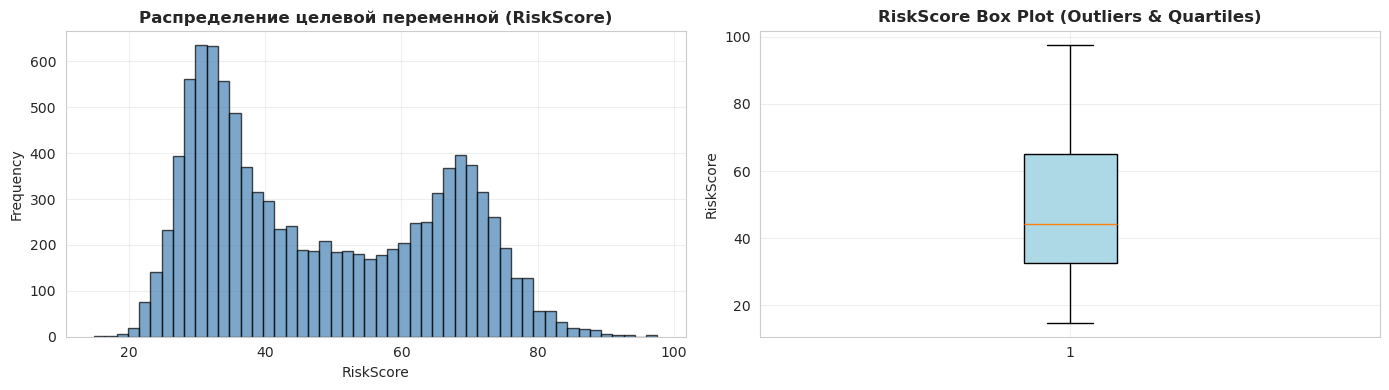


Целевая статистика:
   Mean: 48.36
   Std:  17.24
   Median: 44.20
   Min: 14.84, Max: 97.60


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(train_data['RiskScore'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('Распределение целевой переменной (RiskScore)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('RiskScore')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

axes[1].boxplot(train_data['RiskScore'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue'))
axes[1].set_title('RiskScore Box Plot (Outliers & Quartiles)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('RiskScore')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('01_target_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\nЦелевая статистика:")
print(f"   Mean: {train_data['RiskScore'].mean():.2f}")
print(f"   Std:  {train_data['RiskScore'].std():.2f}")
print(f"   Median: {train_data['RiskScore'].median():.2f}")
print(f"   Min: {train_data['RiskScore'].min():.2f}, Max: {train_data['RiskScore'].max():.2f}")

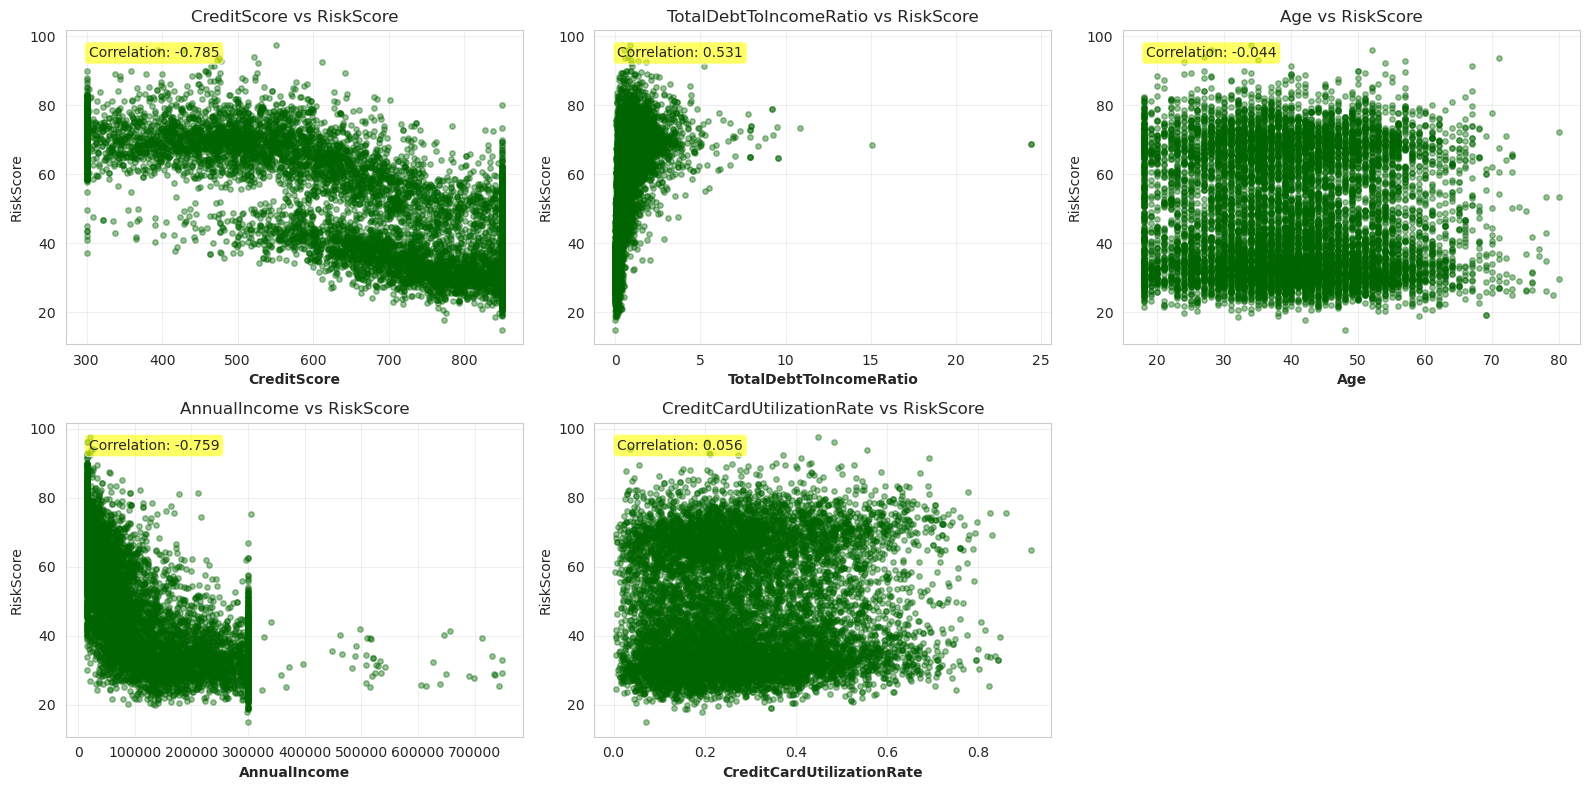

Сгенерированы графики корреляции признаков


In [17]:
key_features = ['CreditScore', 'TotalDebtToIncomeRatio', 'Age',
                'AnnualIncome', 'CreditCardUtilizationRate']

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    if feature in train_data.columns:
        axes[idx].scatter(train_data[feature], train_data['RiskScore'],
                         alpha=0.4, s=15, color='darkgreen')
        axes[idx].set_xlabel(feature, fontweight='bold')
        axes[idx].set_ylabel('RiskScore')
        axes[idx].set_title(f'{feature} vs RiskScore')
        axes[idx].grid(alpha=0.3)
        
        corr_val = train_data[[feature, 'RiskScore']].corr().iloc[0, 1]
        axes[idx].text(0.05, 0.95, f'Correlation: {corr_val:.3f}',
                      transform=axes[idx].transAxes,
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6))

fig.delaxes(axes[5])
plt.tight_layout()
plt.savefig('02_feature_correlations.png', dpi=100, bbox_inches='tight')
plt.show()

print("Сгенерированы графики корреляции признаков")

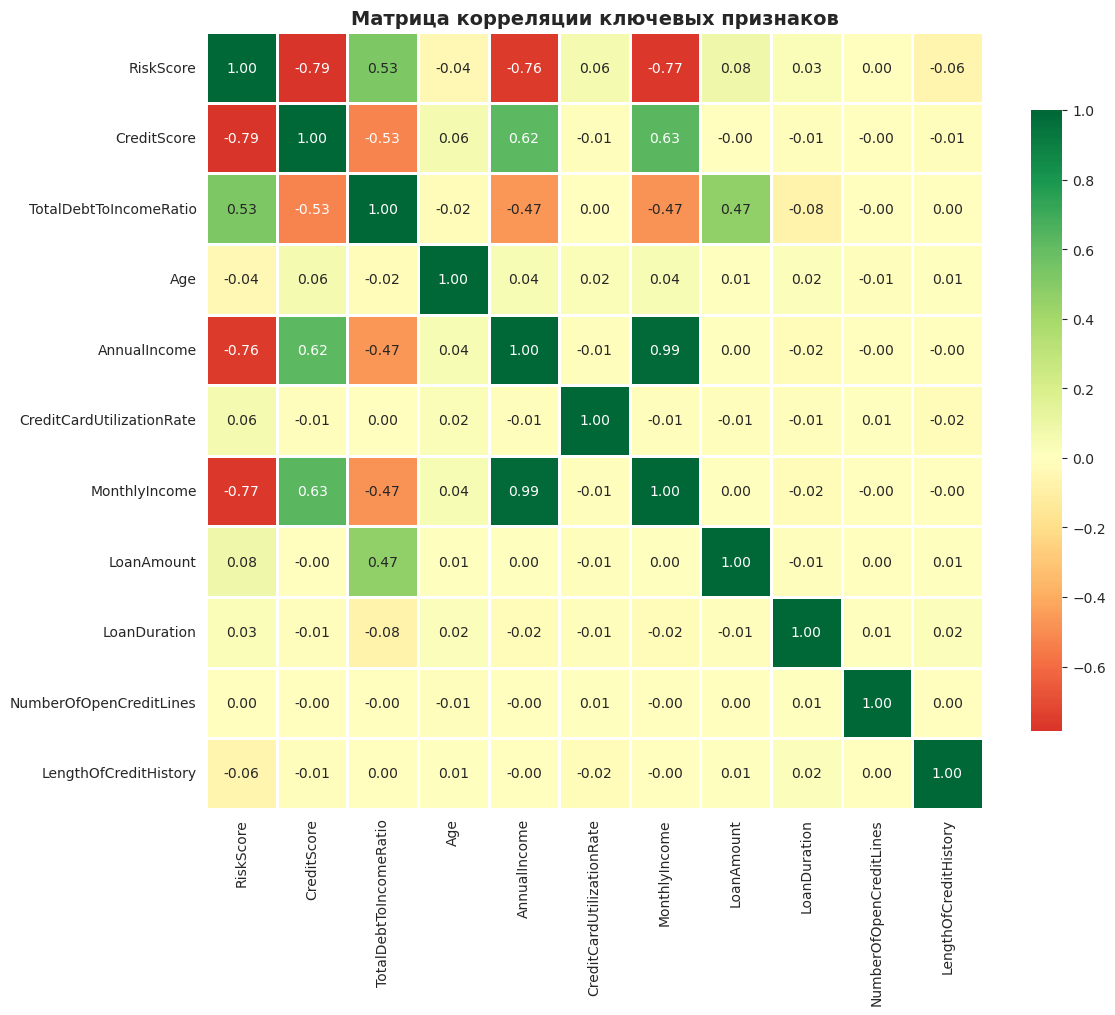

Матрица корреляции сгенерирована

Основные корреляции с RiskScore:
   RiskScore                             1.000000
   BaseInterestRate                      0.758712
   InterestRate                          0.742634
   TotalDebtToIncomeRatio                0.530729
   BankruptcyHistory                     0.177559
   MonthlyLoanPayment                    0.150830
   DebtToIncomeRatio                     0.110862
   LoanAmount                            0.084978
   CreditCardUtilizationRate             0.056063
   PreviousLoanDefaults                  0.054959
   LoanDuration                          0.028269
   UtilityBillsPaymentHistory            0.026535


In [18]:
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()

top_features = ['RiskScore', 'CreditScore', 'TotalDebtToIncomeRatio',
                'Age', 'AnnualIncome', 'CreditCardUtilizationRate',
                'MonthlyIncome', 'LoanAmount', 'LoanDuration',
                'NumberOfOpenCreditLines', 'LengthOfCreditHistory']

available_features = [f for f in top_features if f in numeric_cols]
corr_matrix = train_data[available_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
           square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляции ключевых признаков', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('03_correlation_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

print("Матрица корреляции сгенерирована")

print("\nОсновные корреляции с RiskScore:")
risk_corr = train_data[numeric_cols].corr()['RiskScore'].sort_values(ascending=False)
for feature, corr_val in risk_corr.head(12).items():
    print(f"   {feature:<35} {corr_val:>10.6f}")

## 9. Подготовка данных

In [19]:
print("Применение проектирования функций...")
engineer_features(train_data)
engineer_features(test_data)
print(f"Особенности после проектирования: {train_data.shape[1]}")

print("Извлечение временных характеристик...")
extract_temporal_features(train_data, "ApplicationDate")
extract_temporal_features(test_data, "ApplicationDate")
print("Извлеченные временные характеристики")

education_map = {'High School': 1, 'high school': 1, 'Associate': 2, 'associate': 2,
                 'Bachelor': 3, 'bachelor': 3, 'Master': 4, 'master': 4,
                 'Doctorate': 5, 'PhD': 5, 'phd': 5, 'doctorate': 5}
if 'EducationLevel' in train_data.columns:
    train_data['EducationLevel'] = train_data['EducationLevel'].map(education_map).fillna(0).astype(float)
if 'EducationLevel' in test_data.columns:
    test_data['EducationLevel'] = test_data['EducationLevel'].map(education_map).fillna(0).astype(float)
print("EducationLevel закодирован")

X_train_raw = train_data.drop(columns=['RiskScore'])
if 'ID' in X_train_raw.columns:
    X_train_raw = X_train_raw.drop('ID', axis=1)
y_train_target = train_data['RiskScore']

X_test_raw = test_data.drop(columns=['ID']) if 'ID' in test_data.columns else test_data.copy()

print(f"\nX_train shape: {X_train_raw.shape}")
print(f"y_train shape: {y_train_target.shape}")
print(f"X_test shape: {X_test_raw.shape}")

Применение проектирования функций...
Особенности после проектирования: 121
Извлечение временных характеристик...
Извлеченные временные характеристики
EducationLevel закодирован

X_train shape: (10272, 123)
y_train shape: (10272,)
X_test shape: (5000, 123)


In [20]:
numeric_cols_all = [col for col in X_train_raw.columns if np.issubdtype(X_train_raw[col].dtype, np.number)]
categorical_cols_all = [col for col in X_train_raw.columns if col not in numeric_cols_all]

print(f"Числовые признаки: {len(numeric_cols_all)}")
print(f"Категориальные признаки: {len(categorical_cols_all)}")

print("\nВвод пропущенных значений...")
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

X_numeric_train = numeric_imputer.fit_transform(X_train_raw[numeric_cols_all])
X_categorical_train = categorical_imputer.fit_transform(X_train_raw[categorical_cols_all])

X_numeric_test = numeric_imputer.transform(X_test_raw[numeric_cols_all])
X_categorical_test = categorical_imputer.transform(X_test_raw[categorical_cols_all])

print("Отсутствующие значения вменены")

print("Применение логарифмического преобразования к числовым характеристикам...")
X_numeric_train = signed_logarithm(X_numeric_train)
X_numeric_test = signed_logarithm(X_numeric_test)

ohe_kwargs = {"handle_unknown": "ignore"}
if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False
ohe_encoder = OneHotEncoder(**ohe_kwargs)
X_categorical_train_encoded = ohe_encoder.fit_transform(X_categorical_train)
X_categorical_test_encoded = ohe_encoder.transform(X_categorical_test)
print("One-hot encoding")

X_combined_train = np.hstack([X_numeric_train, X_categorical_train_encoded])
X_combined_test = np.hstack([X_numeric_test, X_categorical_test_encoded])
print(f"\nКомбинированная форма объекта: {X_combined_train.shape[0]} × {X_combined_train.shape[1]}")

Числовые признаки: 110
Категориальные признаки: 13

Ввод пропущенных значений...
Отсутствующие значения вменены
Применение логарифмического преобразования к числовым характеристикам...
One-hot encoding

Комбинированная форма объекта: 10272 × 203


In [21]:
print("Применение нормализации...")

X_minmax_train, minmax_min, minmax_max = minmax_normalize(X_combined_train)
X_minmax_test, _, _ = minmax_normalize(X_combined_test, minmax_min, minmax_max)

X_zscore_train, zscore_mean, zscore_std = zscore_normalize(X_combined_train)
X_zscore_test, _, _ = zscore_normalize(X_combined_test, zscore_mean, zscore_std)

print("Нормализации завершена")
print(f"   Min-Max range: [{X_minmax_train.min():.4f}, {X_minmax_train.max():.4f}]")
print(f"   Z-Score range: [{X_zscore_train.min():.4f}, {X_zscore_train.max():.4f}]")

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_minmax_train, y_train_target, test_size=0.2, random_state=RANDOM_STATE
)
print(f"Train split: {X_train_split.shape}")
print(f"Val split: {X_val_split.shape}")

Применение нормализации...
Нормализации завершена
   Min-Max range: [0.0000, 1.0000]
   Z-Score range: [-11.5050, 101.3459]
Train split: (8217, 203)
Val split: (2055, 203)


## 10. Обучение и оценка моделей

In [22]:
print("\n" + "="*70)
print("МОДЕЛЬ ОБУЧЕНИЯ")
print("="*70)

model_results = {}

print("\n Модель 1: Analytical")
model_analytical = LinearRegressionCustom(method='analytical')
model_analytical.fit(X_train_split, y_train_split)
y_pred_analytical = model_analytical.predict(X_val_split)

mse_a = calc_mse(y_val_split, y_pred_analytical)
mae_a = calc_mae(y_val_split, y_pred_analytical)
rmse_a = calc_rmse(y_val_split, y_pred_analytical)
r2_a = calc_r2(y_val_split, y_pred_analytical)
mape_a = calc_mape(y_val_split, y_pred_analytical)

model_results['analytical'] = {'mse': mse_a, 'rmse': rmse_a, 'mae': mae_a, 'r2': r2_a, 'mape': mape_a}

print(f"   MSE: {mse_a:.6f}  |  RMSE: {rmse_a:.6f}")
print(f"   MAE: {mae_a:.6f}  |  R²: {r2_a:.6f}  |  MAPE: {mape_a:.2f}%")

sklearn_lr = LinearRegression()
sklearn_lr.fit(X_train_split, y_train_split)
y_pred_sklearn = sklearn_lr.predict(X_val_split)
sklearn_mse = mean_squared_error(y_val_split, y_pred_sklearn)
print(f"   vs sklearn MSE: {sklearn_mse:.6f}")

print("\n Модель 2: Gradient Descent (Full-Batch)")
model_gd = LinearRegressionCustom(method='gd', learning_rate=0.01, num_epochs=500)
model_gd.fit(X_train_split, y_train_split)
y_pred_gd = model_gd.predict(X_val_split)

mse_gd = calc_mse(y_val_split, y_pred_gd)
mae_gd = calc_mae(y_val_split, y_pred_gd)
rmse_gd = calc_rmse(y_val_split, y_pred_gd)
r2_gd = calc_r2(y_val_split, y_pred_gd)
mape_gd = calc_mape(y_val_split, y_pred_gd)

model_results['gd'] = {'mse': mse_gd, 'rmse': rmse_gd, 'mae': mae_gd, 'r2': r2_gd, 'mape': mape_gd}

print(f"   MSE: {mse_gd:.6f}  |  RMSE: {rmse_gd:.6f}")
print(f"   MAE: {mae_gd:.6f}  |  R²: {r2_gd:.6f}  |  MAPE: {mape_gd:.2f}%")

print("\n Модель 3: Stochastic Gradient Descent (Mini-Batch)")
model_sgd = LinearRegressionCustom(method='sgd', learning_rate=0.01, num_epochs=500, batch_sz=32)
model_sgd.fit(X_train_split, y_train_split)
y_pred_sgd = model_sgd.predict(X_val_split)

mse_sgd = calc_mse(y_val_split, y_pred_sgd)
mae_sgd = calc_mae(y_val_split, y_pred_sgd)
rmse_sgd = calc_rmse(y_val_split, y_pred_sgd)
r2_sgd = calc_r2(y_val_split, y_pred_sgd)
mape_sgd = calc_mape(y_val_split, y_pred_sgd)

model_results['sgd'] = {'mse': mse_sgd, 'rmse': rmse_sgd, 'mae': mae_sgd, 'r2': r2_sgd, 'mape': mape_sgd}

print(f"   MSE: {mse_sgd:.6f}  |  RMSE: {rmse_sgd:.6f}")
print(f"   MAE: {mae_sgd:.6f}  |  R²: {r2_sgd:.6f}  |  MAPE: {mape_sgd:.2f}%")

print("\n" + "="*70)


МОДЕЛЬ ОБУЧЕНИЯ

 Модель 1: Analytical
   MSE: 28.117899  |  RMSE: 5.302631
   MAE: 3.919008  |  R²: 0.905977  |  MAPE: 9.14%
   vs sklearn MSE: 28.051877

 Модель 2: Gradient Descent (Full-Batch)
   MSE: 42.403925  |  RMSE: 6.511830
   MAE: 4.821896  |  R²: 0.858206  |  MAPE: 11.17%

 Модель 3: Stochastic Gradient Descent (Mini-Batch)
   MSE: 28.679749  |  RMSE: 5.355348
   MAE: 3.964429  |  R²: 0.904098  |  MAPE: 9.28%



In [24]:
validate_metrics_against_sklearn(y_val_split, y_pred_analytical)


ОТЧЕТ О ПРОВЕРКЕ МЕТРИЧЕСКИХ ПОКАЗАТЕЛЕЙ

📊 MEAN SQUARED ERROR (MSE)
   Custom:  28.11789886
   sklearn: 28.11789886
   Сравнение

📊 MEAN ABSOLUTE ERROR (MAE)
   Custom:  3.91900823
   sklearn: 3.91900823
   Сравнение

📊 R² SCORE
   Custom:  0.90597696
   sklearn: 0.90597696
   Сравнение

📊 MEAN ABSOLUTE PERCENTAGE ERROR (MAPE)
   Custom:  9.14215247%
   sklearn: 9.14239292%
   ✗ Mismatch



## 11. Анализ кросс-валидации

In [25]:
print("\n Подготовка к Кросс валидации...")

print("K-Fold (k=5) with Analytical method...")
kf_scores_analytical = kfold_cross_validator(X_minmax_train, y_train_target, k=5, method='analytical')

print("K-Fold (k=5) with GD method...")
kf_scores_gd = kfold_cross_validator(X_minmax_train, y_train_target, k=5, method='gd')

print("Leave-One-Out (LOO) with sampling...")
loo_mse_errors, loo_mae_errors = loocv_cross_validator(X_minmax_train, y_train_target, 
                                                        method='analytical', max_samples=500)

print("Кросс валидация завершена")

summarize_cv_results(kf_scores_analytical, kf_scores_gd, loo_mse_errors)


 Подготовка к Кросс валидации...
K-Fold (k=5) with Analytical method...
K-Fold (k=5) with GD method...
Leave-One-Out (LOO) with sampling...
Кросс валидация завершена

РЕЗУЛЬТАТЫ КРОСС ВАЛИДАЦИИ

K-Fold (Analytical) - MSE: 93.9394 ± 133.3886
   Folds: ['26.7677', '26.6807', '360.7150', '27.6889', '27.8449']

K-Fold (GD) - MSE: 34.0077 ± 1.4431
   Folds: ['32.7417', '33.8028', '35.1196', '32.2550', '36.1194']

Leave-One-Out - MSE: 4835.3371 ± 102784.1279



## 12. Визуализация: сравнение моделей

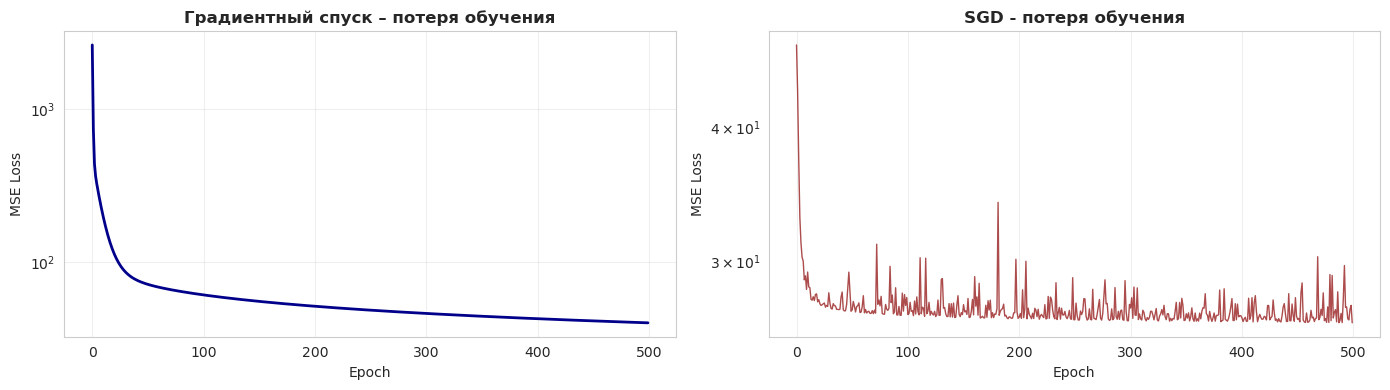

Сохранены кривые потерь при обучении


In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(model_gd.loss_history, linewidth=2, color='darkblue')
axes[0].set_title('Градиентный спуск – потеря обучения', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].grid(alpha=0.3)
axes[0].set_yscale('log')

axes[1].plot(model_sgd.loss_history, linewidth=1, color='darkred', alpha=0.7)
axes[1].set_title('SGD - потеря обучения', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss')
axes[1].grid(alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig('04_training_loss.png', dpi=100, bbox_inches='tight')
plt.show()

print("Сохранены кривые потерь при обучении")

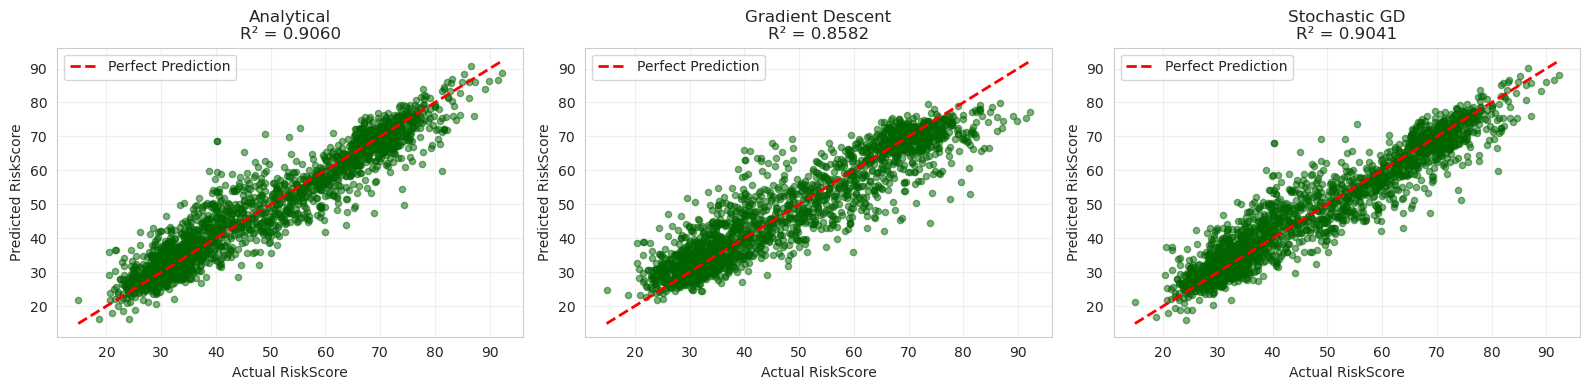

Сравнение прогнозов сохранено


In [29]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for idx, (y_pred, title, model_name) in enumerate([
    (y_pred_analytical, 'Analytical', 'analytical'),
    (y_pred_gd, 'Gradient Descent', 'gd'),
    (y_pred_sgd, 'Stochastic GD', 'sgd')
]):
    axes[idx].scatter(y_val_split, y_pred, alpha=0.5, s=20, color='darkgreen')
    axes[idx].plot([y_val_split.min(), y_val_split.max()],
                   [y_val_split.min(), y_val_split.max()],
                   'r--', lw=2, label='Perfect Prediction')
    axes[idx].set_xlabel('Actual RiskScore')
    axes[idx].set_ylabel('Predicted RiskScore')
    axes[idx].set_title(f'{title}\nR² = {model_results[model_name]["r2"]:.4f}')
    axes[idx].grid(alpha=0.3)
    axes[idx].legend()

plt.tight_layout()
plt.savefig('05_predictions_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("Сравнение прогнозов сохранено")

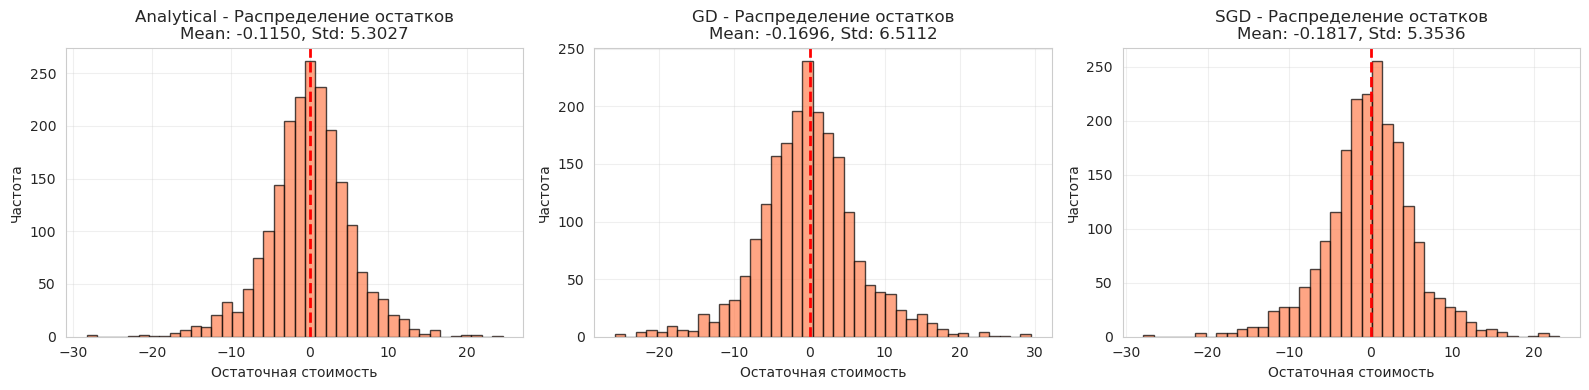

Анализ остатков сохранен


In [32]:
residuals_analytical = y_val_split - y_pred_analytical
residuals_gd = y_val_split - y_pred_gd
residuals_sgd = y_val_split - y_pred_sgd

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for idx, (residuals, title) in enumerate([
    (residuals_analytical, 'Analytical'),
    (residuals_gd, 'GD'),
    (residuals_sgd, 'SGD')
]):
    axes[idx].hist(residuals, bins=40, edgecolor='black', alpha=0.7, color='coral')
    axes[idx].set_title(f'{title} - Распределение остатков\nMean: {residuals.mean():.4f}, Std: {residuals.std():.4f}')
    axes[idx].set_xlabel('Остаточная стоимость')
    axes[idx].set_ylabel('Частота')
    axes[idx].grid(alpha=0.3)
    axes[idx].axvline(0, color='red', linestyle='--', linewidth=2)

plt.tight_layout()
plt.savefig('06_residuals_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("Анализ остатков сохранен")

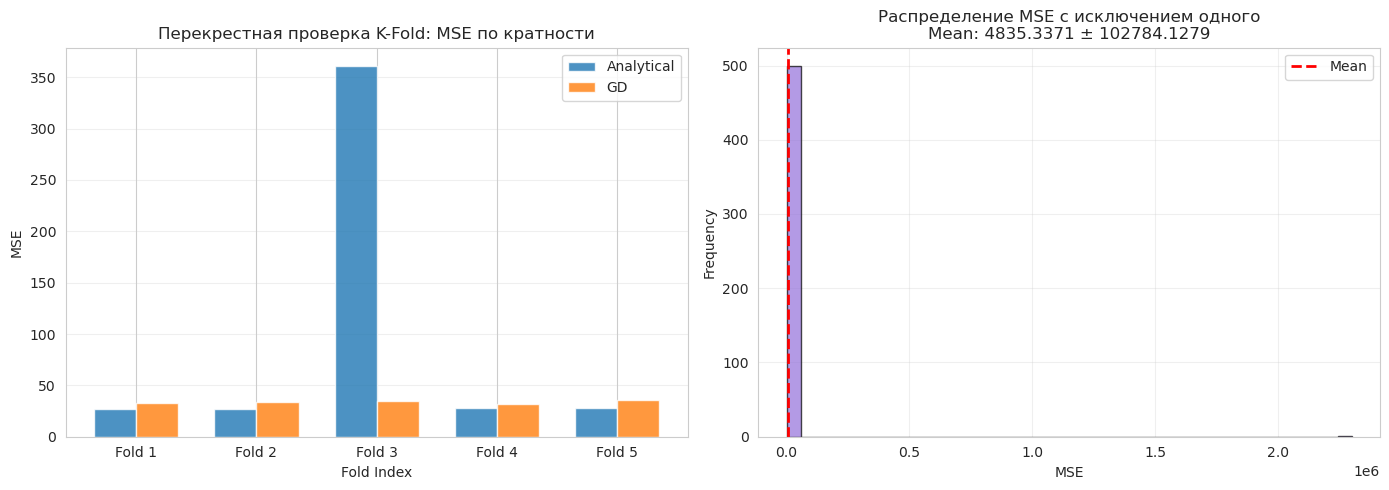

Сохранены графики перекрестной проверки


In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_pos = np.arange(5)
width = 0.35
axes[0].bar(x_pos - width/2, kf_scores_analytical, width, label='Analytical', alpha=0.8)
axes[0].bar(x_pos + width/2, kf_scores_gd, width, label='GD', alpha=0.8)
axes[0].set_xlabel('Fold Index')
axes[0].set_ylabel('MSE')
axes[0].set_title('Перекрестная проверка K-Fold: MSE по кратности')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'Fold {i+1}' for i in range(5)])
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

axes[1].hist(loo_mse_errors, bins=40, edgecolor='black', alpha=0.7, color='mediumpurple')
axes[1].set_title(f'Распределение MSE с исключением одного\nMean: {np.mean(loo_mse_errors):.4f} ± {np.std(loo_mse_errors):.4f}')
axes[1].set_xlabel('MSE')
axes[1].set_ylabel('Frequency')
axes[1].grid(alpha=0.3)
axes[1].axvline(np.mean(loo_mse_errors), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].legend()

plt.tight_layout()
plt.savefig('07_cross_validation.png', dpi=100, bbox_inches='tight')
plt.show()

print("Сохранены графики перекрестной проверки")

## 13. Предсказания ансамбля и отправка

In [38]:
print("\n" + "="*70)
print("ПОСТРОЕНИЕ АНСАМБЛЯ")
print("="*70)

print("\nОбучение ансамблевых моделей на полном датасете...")
ensemble_analytical = LinearRegressionCustom(method='analytical')
ensemble_analytical.fit(X_minmax_train, y_train_target)

ensemble_gd = LinearRegressionCustom(method='gd', learning_rate=0.01, num_epochs=500)
ensemble_gd.fit(X_minmax_train, y_train_target)

ensemble_sgd = LinearRegressionCustom(method='sgd', learning_rate=0.01, num_epochs=500, batch_sz=32)
ensemble_sgd.fit(X_minmax_train, y_train_target)

print("Обучены ансамблевые модели")

print("\nГенерация прогнозов на тестовом наборе...")
test_pred_analytical = ensemble_analytical.predict(X_minmax_test)
test_pred_gd = ensemble_gd.predict(X_minmax_test)
test_pred_sgd = ensemble_sgd.predict(X_minmax_test)

test_predictions_ensemble = 0.5 * test_pred_analytical + 0.25 * test_pred_gd + 0.25 * test_pred_sgd
test_predictions_ensemble = np.clip(test_predictions_ensemble, 0.0, 100.0)

print(f"✓ Сгенерировано ансамблевое предсказание")
print(f"   Range: [{test_predictions_ensemble.min():.2f}, {test_predictions_ensemble.max():.2f}]")
print(f"   Mean: {test_predictions_ensemble.mean():.2f}")
print(f"   Std: {test_predictions_ensemble.std():.2f}")

submission_df = pd.DataFrame({'ID': test_indices, 'RiskScore': test_predictions_ensemble})
submission_df.to_csv('submission.csv', index=False)
print("\nФайл отправки сохранен: submission.csv")


ПОСТРОЕНИЕ АНСАМБЛЯ

Обучение ансамблевых моделей на полном датасете...
Обучены ансамблевые модели

Генерация прогнозов на тестовом наборе...
✓ Сгенерировано ансамблевое предсказание
   Range: [16.14, 91.64]
   Mean: 48.20
   Std: 16.28

Файл отправки сохранен: submission.csv


## 14. Финальный отчёт о производительности

In [39]:
print("\n" + "="*80)
print("ИТОГОВЫЙ ОТЧЕТ")
print("="*80)

metrics_df = pd.DataFrame(model_results).T
print("\nМетрики набора проверок:\n")
print(metrics_df.to_string())

best_model = metrics_df['r2'].idxmax()
print(f"\n Лучшая модель (by R²): {best_model.upper()}")
print(f"   R² Оценка: {metrics_df.loc[best_model, 'r2']:.6f}")


ИТОГОВЫЙ ОТЧЕТ

Метрики набора проверок:

                  mse      rmse       mae        r2       mape
analytical  28.117899  5.302631  3.919008  0.905977   9.142152
gd          42.403925  6.511830  4.821896  0.858206  11.172152
sgd         28.679749  5.355348  3.964429  0.904098   9.280438

 Лучшая модель (by R²): ANALYTICAL
   R² Оценка: 0.905977


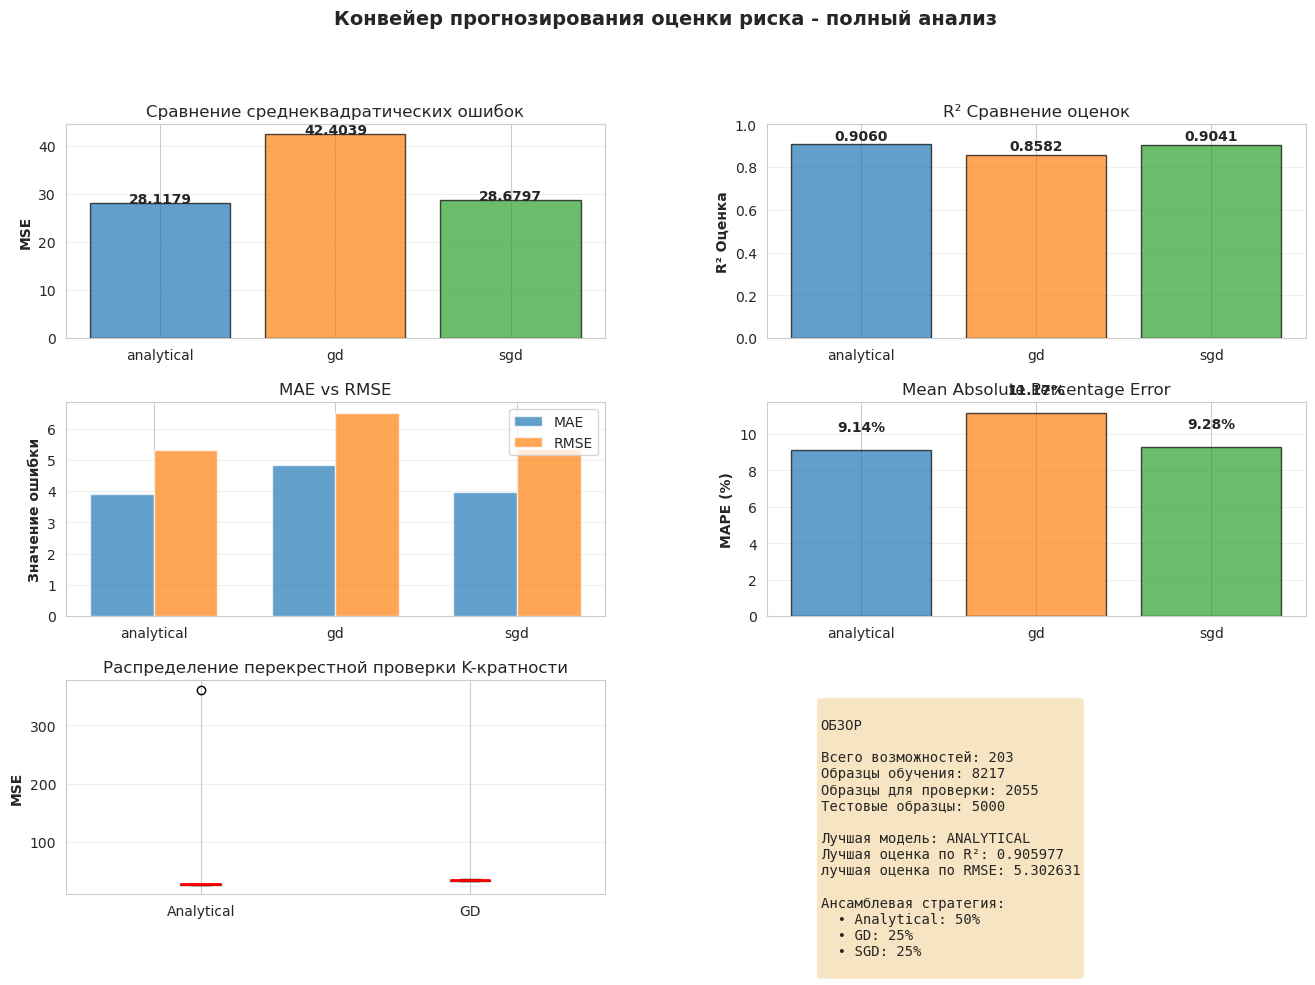


 Визуализация итогового отчета сохранена


In [41]:
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
models = list(model_results.keys())
mse_vals = [model_results[m]['mse'] for m in models]
colors_bar = ['#1f77b4', '#ff7f0e', '#2ca02c']
ax1.bar(models, mse_vals, color=colors_bar, alpha=0.7, edgecolor='black')
ax1.set_ylabel('MSE', fontweight='bold')
ax1.set_title('Сравнение среднеквадратических ошибок')
ax1.grid(alpha=0.3, axis='y')
for i, v in enumerate(mse_vals):
    ax1.text(i, v + 0.05, f'{v:.4f}', ha='center', fontweight='bold')

ax2 = fig.add_subplot(gs[0, 1])
r2_vals = [model_results[m]['r2'] for m in models]
ax2.bar(models, r2_vals, color=colors_bar, alpha=0.7, edgecolor='black')
ax2.set_ylabel('R² Оценка', fontweight='bold')
ax2.set_title('R² Сравнение оценок')
ax2.grid(alpha=0.3, axis='y')
ax2.set_ylim([0, 1])
for i, v in enumerate(r2_vals):
    ax2.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

ax3 = fig.add_subplot(gs[1, 0])
mae_vals = [model_results[m]['mae'] for m in models]
rmse_vals = [model_results[m]['rmse'] for m in models]
x_pos_metrics = np.arange(len(models))
width_metrics = 0.35
ax3.bar(x_pos_metrics - width_metrics/2, mae_vals, width_metrics, label='MAE', alpha=0.7)
ax3.bar(x_pos_metrics + width_metrics/2, rmse_vals, width_metrics, label='RMSE', alpha=0.7)
ax3.set_ylabel('Значение ошибки', fontweight='bold')
ax3.set_title('MAE vs RMSE')
ax3.set_xticks(x_pos_metrics)
ax3.set_xticklabels(models)
ax3.legend()
ax3.grid(alpha=0.3, axis='y')

ax4 = fig.add_subplot(gs[1, 1])
mape_vals = [model_results[m]['mape'] for m in models]
ax4.bar(models, mape_vals, color=colors_bar, alpha=0.7, edgecolor='black')
ax4.set_ylabel('MAPE (%)', fontweight='bold')
ax4.set_title('Mean Absolute Percentage Error')
ax4.grid(alpha=0.3, axis='y')
for i, v in enumerate(mape_vals):
    ax4.text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')

ax5 = fig.add_subplot(gs[2, 0])
cv_data = [kf_scores_analytical, kf_scores_gd]
ax5.boxplot(cv_data, labels=['Analytical', 'GD'], patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax5.set_ylabel('MSE', fontweight='bold')
ax5.set_title('Распределение перекрестной проверки K-кратности')
ax5.grid(alpha=0.3, axis='y')

ax6 = fig.add_subplot(gs[2, 1])
ax6.axis('off')
summary_text = f"""
ОБЗОР

Всего возможностей: {X_minmax_train.shape[1]}
Образцы обучения: {X_train_split.shape[0]}
Образцы для проверки: {X_val_split.shape[0]}
Тестовые образцы: {X_minmax_test.shape[0]}

Лучшая модель: {best_model.upper()}
Лучшая оценка по R²: {metrics_df.loc[best_model, 'r2']:.6f}
лучшая оценка по RMSE: {metrics_df.loc[best_model, 'rmse']:.6f}

Ансамблевая стратегия:
  • Analytical: 50%
  • GD: 25%
  • SGD: 25%
"""
ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
        family='monospace')

plt.suptitle('Конвейер прогнозирования оценки риска - полный анализ', 
             fontsize=14, fontweight='bold', y=0.995)

plt.savefig('08_final_report.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n Визуализация итогового отчета сохранена")

In [42]:
print("\n" + "="*80)
print("ПОДРОБНАЯ СТАТИСТИКА")
print("="*80)

print("\n Набор для проверки (аналитическая модель):")
print(f"   Predictions - Min: {y_pred_analytical.min():.2f}, Max: {y_pred_analytical.max():.2f}")
print(f"   Predictions - Mean: {y_pred_analytical.mean():.2f}, Std: {y_pred_analytical.std():.2f}")
print(f"   Actual - Min: {y_val_split.min():.2f}, Max: {y_val_split.max():.2f}")
print(f"   Actual - Mean: {y_val_split.mean():.2f}, Std: {y_val_split.std():.2f}")

print("\n Прогнозы тестового набора (ансамбль):")
print(f"   Min: {test_predictions_ensemble.min():.2f}")
print(f"   Max: {test_predictions_ensemble.max():.2f}")
print(f"   Mean: {test_predictions_ensemble.mean():.2f}")
print(f"   Std: {test_predictions_ensemble.std():.2f}")
print(f"   Median: {np.median(test_predictions_ensemble):.2f}")

print("\n Статистика перекрестной проверки:")
print(f"   K-Fold (Analytical): {np.mean(kf_scores_analytical):.4f} ± {np.std(kf_scores_analytical):.4f}")
print(f"   K-Fold (GD): {np.mean(kf_scores_gd):.4f} ± {np.std(kf_scores_gd):.4f}")
print(f"   LOO: {np.mean(loo_mse_errors):.4f} ± {np.std(loo_mse_errors):.4f}")


ПОДРОБНАЯ СТАТИСТИКА

 Набор для проверки (аналитическая модель):
   Predictions - Min: 16.05, Max: 90.65
   Predictions - Mean: 48.01, Std: 16.53
   Actual - Min: 14.84, Max: 92.27
   Actual - Mean: 47.89, Std: 17.30

 Прогнозы тестового набора (ансамбль):
   Min: 16.14
   Max: 91.64
   Mean: 48.20
   Std: 16.28
   Median: 45.26

 Статистика перекрестной проверки:
   K-Fold (Analytical): 93.9394 ± 133.3886
   K-Fold (GD): 34.0077 ± 1.4431
   LOO: 4835.3371 ± 102784.1279
